In [15]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd
import seaborn as sns
import ujson
import sys
import time
import itertools
import pickle

from tqdm.auto import tqdm
from collections import defaultdict
from matplotlib import pyplot as plt
from bigbio.dataloader import BigBioConfigHelpers

sys.path.append('..')
from bigbio_utils import dataset_to_df, DATASET_NAMES, CUIS_TO_EXCLUDE, CUIS_TO_REMAP, resolve_abbreviation, dataset_to_documents
from dataset_consts import dataset_to_pretty_name, model_to_pretty_name, model_to_color

conhelps = BigBioConfigHelpers()
sns.set()
sns.set_style("whitegrid")

models = ['sapbert','metamap','krissbert','scispacy','medlinker', 'arboel_biencoder','arboel_crossencoder','biobart', 'biogenel']

to_add = ['bern2','bootleg']

pd.set_option('display.max_columns', 80)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def metamap_to_candidates(metamap_output, mappings_first=False):
    if mappings_first:
        cols = ["text", "mapping_cui_list", "candidate_cui_list"]
    else:
        cols = ["text", "candidate_cui_list", "mapping_cui_list",]
            
    # Create mapping from text to candidates for MedMentions
    text2candidates = defaultdict(list)

    for row in metamap_output[cols].values:
        text = row[0]
        candidates = eval(row[1]) 
        for c in eval(row[2]):
            candidates
        # TODO: Need to account for correct database for 
        candidates = [["UMLS:" + x if ":" not in x else x.replace('ncbigene', 'NCBIGene')] for x in candidates ]
        text2candidates[text] = candidates

    return text2candidates


def deduplicate_candidates(candidates, return_counts=False):
    deduplicated = []
    counts = defaultdict(int)
    for c in candidates:
        if type(c) == list:
            deduped_subset =[x for x in c if x not in counts]
            if len(deduped_subset) > 0:
                deduplicated.append(deduped_subset)

            for x in c:
                counts[x] += 1
            
        else:        
            counts[c] += 1
            if c not in deduplicated:
                deduplicated.append(c)

    if return_counts:
        return deduplicated, counts

    return deduplicated



def output_list_to_candidates(output_list, k=20, sort_by_counts=False):
    '''
    Turn model output into candidate list
    '''
    output2candidates = defaultdict(list)
    for mention in output_list:
        doc_id = mention['document_id']
        offsets = mention['offsets']
        joined_offsets = ';'.join([','.join([str(y) for y in x]) for x in offsets])
        # candidates = [y for x in mention['candidates'] for y in x]
        candidates = mention['candidates']
        deduplicated_candidates, counts = deduplicate_candidates(candidates, return_counts=True)

        # Syntax to prioritize candidates that come up more frequently in retrieved results
        if sort_by_counts:
            top_cuis = sorted([(k,v) for k, v in counts.items()], key=lambda x: x[1], reverse=True)
            grouped_candidates = []
            for k, g in itertools.groupby(top_cuis, key=lambda x: x[1]):
                grouped_candidates.append(list(g))

            output2candidates[(doc_id, joined_offsets)] = grouped_candidates
        else:
            output2candidates[(doc_id, joined_offsets)] = deduplicated_candidates[:k]
    
    return output2candidates


def add_candidates_to_df(df, candidate_dict, new_col_name, eval_col='text'):
    '''
    Add candidates produced by a model to results dataframe for evaluation

    Parameters:
    ----------------------------
        df: pandas.DataFrame
            Dataframe of bigbio mention produced by bigbio_utils.dataset_to_df

        candidate_dict: dict
            Mapping of (document_id, joined_offsets) -> candidates

        new_col_name: str
            Name of new column

        eval_col: Column to evaluate on
    '''
    df[new_col_name] = df[['document_id', 'joined_offsets']].apply(lambda x: candidate_dict[(x[0], x[1])], axis=1)

def list_flatten(nested_list):
    used = set([])
    flattened = []
    for x in nested_list:
        for y in x:
            if y not in used:
                flattened.append(y)
                used.add(y)

    return flattened

def min_hit_index(gold_cuis, candidates, eval_mode):
    '''
    Find index of first hit in candidates
    '''
    if eval_mode == 'basic':
        flat_candidates = list_flatten(candidates)
        for i, c in enumerate(flat_candidates):
            if c in gold_cuis:
                return i
    elif eval_mode == 'strict':
        for i, c in enumerate(candidates):
            if all(x in gold_cuis for x in c):
                return i
            
    elif eval_mode == 'relaxed':
        for i, c in enumerate(candidates):
            if any(x in gold_cuis for x in c):
                return i
            
    else:
        raise ValueError(f"eval_mode {eval_mode} not supported")

    return 1000000




def recall_at_k(df, candidate_col, gold_col='db_ids', max_k: int=10, filter_null=False, eval_mode='basic'):
    '''
    Compute recall@k for all values of k < max_k
    '''
    # Filter rows wilt null values after CUI remapping
    if filter_null:
        before_row_count = df.shape[0]
        df = df[df[gold_col].map(lambda x: len(x) > 0)]
        after_row_count = df.shape[0]
        print(f"Dropped {before_row_count - after_row_count} rows with null db_ids")


    df[f'{candidate_col}_min_hit_index'] = df[[gold_col, candidate_col]].apply(lambda x: min_hit_index(x[0], x[1], eval_mode=eval_mode), axis=1)

    recall_at_k_dict = {}
    for k in range(1, max_k + 1):
        recall_at_k_dict[k] = (df[f'{candidate_col}_min_hit_index'] < k).mean()

    return recall_at_k_dict


def plot_recall_at_k(recall_dict, max_k=10, legend_key=None, ax=None, color=None, alpha=1):
    if ax is not None:
        ax.plot(recall_dict.keys(), recall_dict.values(), marker='o', label=legend_key, color=color, alpha=alpha)
    else:
        plt.plot(recall_dict.keys(), recall_dict.values(), marker='o', label=legend_key, color=color, alpha=alpha)
    # if legend_key is not None:
    #     plt.legend()
    

def correct_medlinker_candidates(medlinker_output):
    for x in medlinker_output:
        new_candidates = []
        for y in x['candidates']:
            single_candidate = []
            for c in y:
                if c is None:
                    continue
                if not c.startswith('MESH') and not c.startswith("OMIM"):
                    c = c.replace('ESH', "MESH")
                single_candidate.append(c)
            new_candidates.append(single_candidate)
        x['candidates'] = new_candidates
    return medlinker_output

# Load in results

In [35]:

full_results = {}


for name in DATASET_NAMES:
# for name in ['ncbi_disease']:
    # old_name = name
    # inds = dataset_to_subplot[name]
    # if inds is not None:
    #     ax = axs[inds[0], inds[1]]
    #     ax.title.set_text(dataset_to_pretty_name[name])
    

    ### CHANGE before final run!!!
    # name='bc5cdr'
    print(name)


    # Load dataset and deduplicate + remove deprecated identifiers
    df = pd.read_feather(f'../results/scispacy/{name}_scispacy.feather').drop(['index','scores',], axis=1)
    df = df.rename({"mention_text": "deabbreviated_text"}, axis=1)
    df['joined_offsets'] = df.offsets.map(lambda offsets: ';'.join([','.join([str(y) for y in x]) for x in offsets]))
    if 'remapped_db_ids' not in df.columns:
        df['remapped_db_ids'] = df['db_ids']

    # MetaMap results
    metamap_output = pd.read_csv(f'../results/metamap/{name}.csv', na_filter=False)
    mm_candidates = metamap_to_candidates(metamap_output)

    df['metamap'] = df.text.map(mm_candidates)
    df['metamap_resolve_abbrev'] = df.deabbreviated_text.map(mm_candidates)

    # Medlinker
    medlinker_output = ujson.load(open(f'../results/medlinker/{name}.json'))
    medlinker_output = correct_medlinker_candidates(medlinker_output)
    corrected_medlinker_output = []
    for x in medlinker_output:
        for y in x['candidates']:
            for c in y:
                if c is None:
                    continue
                if c.startswith('ESH'):
                    c = c.replace('ESH', 'MESH')
                    print(c)
    medlinker2candidates = output_list_to_candidates(medlinker_output)
    add_candidates_to_df(df, medlinker2candidates, 'medlinker')

    # # BioGenEL
    # biogen_dict = ujson.load(open('../biogenel/src/bigbio_/output/bc5cdr.json'))
    # db_ids = [x['db_ids'] for x in biogen]
    # biogen_candidates = [[z for y in  x['candidates'] for z in y] for x in biogen_dict]
    # df['biogenel'] = biogen_candidates


    # SapBERT and KRISSBERT
    for model in ['sapbert','krissbert']:
        for resolve_abbr in [False, True]:
        # for resolve_abbr in [False]:
            if resolve_abbr:
                new_col_name = f"{model}_resolve_abbrev"
                subdir = 'with_abbr_res'
            else:
                new_col_name = f"{model}"
                subdir = 'no_abbr_res'
            model_output = ujson.load(open(f'../results/{model}/{subdir}/{name}.json'))
            model2candidates = output_list_to_candidates(model_output)
            add_candidates_to_df(df, model2candidates, new_col_name)


    # ArboEL
    biencoder_results = ujson.load(open(f'../results/arboel_biencoder/{name}.json'))['mentions_with_candidates']
    if name == 'ncbi_disease':
        synsets = ujson.load(open('../data/arboel/ncbi_disease/cui_synsets.json'))
        for x in biencoder_results:
            x['candidates'] = [synsets[y] for y in x['candidates']]
            # x['candidates'] = [z for y in x['candidates'] for z in synsets[y]]

    else:
        for x in biencoder_results:
            x['candidates'] = [[y] for y in x['candidates']]

    biencoder_dict = {x['mention_id']: {'db_ids': x['db_ids'], 'candidates': x['candidates']} for x in biencoder_results if 'abbr' not in x['mention_id']}
    biencoder_resolve_abbr_dict = {x['mention_id'].rstrip('.abbr_resolved'): {'db_ids': x['db_ids'], 'candidates': x['candidates']} for x in biencoder_results if 'abbr' in x['mention_id']}

    df['arboel_biencoder'] = df['mention_id'].map(lambda x: biencoder_dict[x]['candidates'] if x in biencoder_dict else [[] * 20])
    df['arboel_biencoder_resolve_abbrev'] = df['mention_id'].map(lambda x: biencoder_resolve_abbr_dict[x]['candidates']if x in biencoder_resolve_abbr_dict else [[] * 20])


    if name != 'medmentions_full':
        crossencoder_results = ujson.load(open(f'../results/arboel_crossencoder/{name}.json'))['predicted_candidates']
        crossencoder_dict = {key: [[x] for x in val] for key, val in crossencoder_results.items() if "abbr" not in key}
        crossencoder_resolve_abbr_dict = {key.rstrip('.abbr_resolved'): [[x] for x in val] for key, val in crossencoder_results.items() if "abbr" in key}
        df['arboel_crossencoder'] = df['mention_id'].map(lambda x: crossencoder_dict[x] if x in crossencoder_dict else [[] * 20])
        df['arboel_crossencoder_resolve_abbrev'] = df['mention_id'].map(lambda x: crossencoder_resolve_abbr_dict[x] if x in crossencoder_resolve_abbr_dict else [[] * 20])


    # BioGenEL
    biogenel_results = ujson.load(open(f'../results/biogenel/with_abbr_res/{name}.json'))
    df['biogenel_resolve_abbrev'] = [x['candidates']for x in biogenel_results]
    # df['biogenel'] = [[z for y in x['candidates'] for z in y] for x in biogenel_results ]

    biobart_results = ujson.load(open(f'../results/biobart/with_abbr_res/{name}.json'))
    biobart_no_abbr_results = ujson.load(open(f'../results/biobart/with_abbr_res/{name}.json'))
    df['biobart_resolve_abbrev'] = [x['candidates'] for x in biobart_results]
    df['biobart'] = [x['candidates'] for x in biobart_no_abbr_results]
    # df['biobart'] = [[z for y in x['candidates'] for z in y] for x in biobart_results ]

    
    full_results[name] = df
with open(f'../results/complete_results.pickle','wb') as f:
    pickle.dump(full_results, f)

# with open(f'../results/complete_results_dfs/eval_strategy:{eval_strategy}_resolve_abbrev:{use_resolved_abbrevs}.pickle') as f:
#         pickle.dump(full_results, f)




bc5cdr
medmentions_full
medmentions_st21pv
gnormplus
nlmchem
nlm_gene
ncbi_disease


In [30]:
full_results['nlm_gene']

,document_id,offsets,text,type,db_ids,split,mention_id,remapped_db_ids,deabbreviated_text,scispacy,scispacy_resolve_abbrev,joined_offsets,metamap,metamap_resolve_abbrev,medlinker,sapbert,sapbert_resolve_abbrev,krissbert,krissbert_resolve_abbrev,arboel_biencoder,arboel_biencoder_resolve_abbrev,arboel_crossencoder,arboel_crossencoder_resolve_abbrev,biogenel_resolve_abbrev,biobart_resolve_abbrev,scispacy_min_hit_index,scispacy_resolve_abbrev_min_hit_index,metamap_min_hit_index,metamap_resolve_abbrev_min_hit_index,medlinker_min_hit_index,sapbert_min_hit_index,sapbert_resolve_abbrev_min_hit_index,krissbert_min_hit_index,krissbert_resolve_abbrev_min_hit_index,biogenel_resolve_abbrev_min_hit_index,biobart_resolve_abbrev_min_hit_index,arboel_biencoder_min_hit_index,arboel_biencoder_resolve_abbrev_min_hit_index,arboel_crossencoder_min_hit_index,arboel_crossencoder_resolve_abbrev_min_hit_index
0,12486105,"[[70, 77]]",DEC-205,[GENERIF],[NCBIGene:17076],test,12486105.1,[],DEC-205,"[[UMLS:C1416939, UMLS:C0297523, UMLS:C0621894,...","[[UMLS:C1416939, UMLS:C0297523, UMLS:C0621894,...","70,77",[[NCBIGene:4065]],[[NCBIGene:4065]],"[[NCBIGene:17076], [NCBIGene:100526664], [NCBI...","[[NCBIGene:4065, NCBIGene:100526664, NCBIGene:...","[[NCBIGene:4065, NCBIGene:100526664, NCBIGene:...","[[NCBIGene:56644], [NCBIGene:17076], [NCBIGene...","[[NCBIGene:56644], [NCBIGene:17076], [NCBIGene...","[[NCBIGene:17470], [NCBIGene:387201], [NCBIGen...","[[NCBIGene:17470], [NCBIGene:387201], [NCBIGen...",[[]],[[]],"[[NCBIGene:4065, NCBIGene:100526664, NCBIGene:...","[[NCBIGene:4065, NCBIGene:100526664, NCBIGene:...",1000000,1000000,1000000,1000000,0,1000000,1000000,1,1,1000000,1000000,1000000,1000000,0,0
1,12486105,"[[131, 171]]",major histocompatibility complex class I,[STARGENE],[NCBIGene:14972],test,12486105.2,[],major histocompatibility complex class I,"[[UMLS:C1440752, UMLS:C2334737, UMLS:C4543342,...","[[UMLS:C1440752, UMLS:C2334737, UMLS:C4543342,...","131,171",[],[],"[[NCBIGene:101118514], [NCBIGene:539241], [NCB...","[[NCBIGene:512672], [NCBIGene:368566, NCBIGene...","[[NCBIGene:512672], [NCBIGene:368566, NCBIGene...","[[NCBIGene:447287, NCBIGene:100127725], [NCBIG...","[[NCBIGene:447287, NCBIGene:100127725], [NCBIG...","[[NCBIGene:109700], [NCBIGene:3108], [NCBIGene...","[[NCBIGene:109700], [NCBIGene:3108], [NCBIGene...",[[]],[[]],"[[NCBIGene:100127185, NCBIGene:100127707], [NC...","[[NCBIGene:100006947, NCBIGene:100006993, NCBI...",1000000,1000000,1000000,1000000,6,1000000,1000000,6,6,1000000,1000000,1000000,1000000,0,0
2,12486105,"[[196, 199]]",CD8,[Gene],[NCBIGene:12526],test,12486105.3,[],CD8,"[[UMLS:C0085358, UMLS:C1413244, UMLS:C1706438,...","[[UMLS:C0085358, UMLS:C1413244, UMLS:C1706438,...","196,199",[],[],"[[NCBIGene:12525], [NCBIGene:100006534], [NCBI...","[[NCBIGene:100653505, NCBIGene:108706508, NCBI...","[[NCBIGene:100653505, NCBIGene:108706508, NCBI...","[[NCBIGene:12525, NCBIGene:12526], [NCBIGene:1...","[[NCBIGene:12526, NCBIGene:12525], [NCBIGene:1...","[[NCBIGene:12526], [NCBIGene:12525], [NCBIGene...","[[NCBIGene:12526], [NCBIGene:12525], [NCBIGene...","[[NCBIGene:12526], [NCBIGene:12525], [NCBIGene...","[[NCBIGene:12526], [NCBIGene:12525], [NCBIGene...","[[NCBIGene:677754], [NCBIGene:634, NCBIGene:61...","[[NCBIGene:36335686, NCBIGene:26195, NCBIGene:...",1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,1000000,2,1,0,0,0,0
3,12486105,"[[319, 365]]",major histocompatibility complex (MHC) class I,[STARGENE],[NCBIGene:14972],test,12486105.4,[],major histocompatibility complex (MHC) class I,"[[UMLS:C0024518, UMLS:C1440752, UMLS:C2334737,...","[[UMLS:C0024518, UMLS:C1440752, UMLS:C2334737,...","319,365",[],[],"[[NCBIGene:539241], [NCBIGene:15013], [NCBIGen...","[[NCBIGene:512672], [NCBIGene:368566, NCBIGene...","[[NCBIGene:512672], [NCBIGene:368566, NCBIGene...","[[NCBIGene:14972], [NCBIGene:3123], [NCBIGene:...","[[NCBIGene:14972], [NCBIGene:3123], [NCBIGene:...","[[NCBIGene:3108], [NCBIGene:328949], [NCBIGene...","[[NCB

In [2]:
with open(f'../results/complete_results.pickle','rb') as f:
        full_results = pickle.load(f)

full_results['ncbi_disease']

,document_id,offsets,text,type,db_ids,split,mention_id,remapped_db_ids,deabbreviated_text,scispacy,scispacy_resolve_abbrev,joined_offsets,metamap,metamap_resolve_abbrev,medlinker,sapbert,sapbert_resolve_abbrev,krissbert,krissbert_resolve_abbrev,arboel_biencoder,arboel_biencoder_resolve_abbrev,arboel_crossencoder,arboel_crossencoder_resolve_abbrev,biogenel_resolve_abbrev,biobart_resolve_abbrev,biobart
0,9288106,"[[40, 61]]",ataxia-telangiectasia,[Modifier],[MESH:D001260],test,9288106.1,[UMLS:C0004135],ataxia-telangiectasia,"[[UMLS:C0004135, UMLS:C1705846, UMLS:C1876175,...","[[UMLS:C0004135, UMLS:C1705846, UMLS:C1876175,...","40,61","[[MESH:D001260], [MESH:D001259], [MESH:D002524...","[[MESH:D001260], [MESH:D001259], [MESH:D002524...","[[OMIM:208900], [MESH:D001260], [MESH:C566865]...","[[MESH:D001260, OMIM:208900], [MESH:C565779, O...","[[MESH:D001260, OMIM:208900], [MESH:C565779, O...","[[MESH:D001260], [OMIM:604391], [OMIM:208900],...","[[MESH:D001260], [OMIM:604391], [OMIM:208900],...","[[MESH:D001260, OMIM:208900], [MESH:D007636], ...","[[MESH:D001260, OMIM:208900], [MESH:D007636], ...","[[MESH:D001260], [MESH:C566865], [MESH:D001259...","[[MESH:D001260], [MESH:C566865], [MESH:D001259...","[[MESH:D001260, OMIM:208900], [MESH:D001260, O...","[[MESH:D020754, OMIM:164400, OMIM:164500, OMIM...","[[MESH:D020754, OMIM:164400, OMIM:164500, OMIM..."
1,9288106,"[[72, 97]]",sporadic T-cell leukaemia,[SpecificDisease],[MESH:D015458],test,9288106.2,[UMLS:C0023492],sporadic T-cell leukaemia,"[[UMLS:C0023493, UMLS:C2363142, UMLS:C0020094,...","[[UMLS:C0023493, UMLS:C2363142, UMLS:C0020094,...","72,97","[[MESH:D015458], [MESH:D013601], [MESH:D002477...","[[MESH:D015458], [MESH:D013601], [MESH:D002477...","[[MESH:D015458], [MESH:D015448], [MESH:D015459...","[[MESH:D015458], [MESH:D015459]]","[[MESH:D015458], [MESH:D015459]]","[[MESH:D016399], [MESH:D001260], [MESH:D009369...","[[MESH:D016399], [MESH:D001260], [MESH:D009369...","[[MESH:D015458], [MESH:D016399], [MESH:D007938...","[[MESH:D015458], [MESH:D016399], [MESH:D007938...","[[MESH:D015458], [MESH:D016399], [MESH:D002471...","[[MESH:D015458], [MESH:D016399], [MESH:D002471...","[[MESH:D012175, OMIM:180200], [MESH:D012175, O...","[[MESH:D025242], [MESH:D025242], [MESH:D015463...","[[MESH:D025242], [MESH:D025242], [MESH:D015463..."
2,9288106,"[[99, 120]]",Ataxia-telangiectasia,[SpecificDisease],[MESH:D001260],test,9288106.3,[UMLS:C0004135],Ataxia-telangiectasia,"[[UMLS:C0004135, UMLS:C1705846, UMLS:C1876175,...","[[UMLS:C0004135, UMLS:C1705846, UMLS:C1876175,...","99,120","[[MESH:D001260], [MESH:D001259], [MESH:D002524...","[[MESH:D001260], [MESH:D001259], [MESH:D002524...","[[OMIM:208900], [MESH:D001260], [MESH:C566865]...","[[MESH:D001260, OMIM:208900], [MESH:C565779, O...","[[MESH:D001260, OMIM:208900], [MESH:C565779, O...","[[MESH:D001260], [OMIM:604391], [MESH:D030342]...","[[MESH:D001260], [OMIM:604391], [MESH:D030342]...","[[MESH:D001260, OMIM:208900], [MESH:D007636], ...","[[MESH:D001260, OMIM:208900], [MESH:D007636], ...","[[MESH:D001260], [MESH:C566865], [MESH:C565380...","[[MESH:D001260], [MESH:C566865], [MESH:C565380...","[[MESH:D001260, OMIM:208900], [MESH:D001260, O...","[[MESH:D020754, OMIM:164400, OMIM:164500, OMIM...","[[MESH:D020754, OMIM:164400, OMIM:164500, OMIM..."
3,9288106,"[[122, 125]]",A-T,[SpecificDisease],[MESH:D001260],test,9288106.4,[UMLS:C0004135],Ataxia-telangiectasia,"[[UMLS:C0298973, UMLS:C0071348, UMLS:C3711796,...","[[UMLS:C0004135, UMLS:C1705846, UMLS:C1876175,...","122,125",[],"[[MESH:D001260], [MESH:D001259], [MESH:D002524...","[[MESH:D001260], [MESH:D017085], [OMIM:604131]...","[[MESH:D001260, OMIM:208900], [MESH:C536783], ...","[[MESH:D001260, OMIM:208900], [MESH:C565779, O...","[[MESH:D001260], [OMIM:604391], [MESH:D030342]...","[[MESH:D001260], [OMIM:604391], [MESH:D030342]...","[[MESH:D001260, OMIM:208900], [MESH:D007636], ...","[[MESH:D001260, OMIM:208900], [MESH:D007636], ...","[[MESH:D001260], [MESH:C566865], [MESH:C565380...","[[MESH:D00126

In [4]:
full_results['nlm_gene'].scispacy_min_hit_index.value_counts()

AttributeError: 'DataFrame' object has no attribute 'scispacy_min_hit_index'

In [12]:
df

,document_id,offsets,text,type,db_ids,split,mention_id,remapped_db_ids,deabbreviated_text,scispacy,scispacy_resolve_abbrev,joined_offsets,metamap,metamap_resolve_abbrev,medlinker,sapbert,sapbert_resolve_abbrev,krissbert,krissbert_resolve_abbrev,arboel_biencoder,arboel_biencoder_resolve_abbrev,arboel_crossencoder,arboel_crossencoder_resolve_abbrev,biogenel,biobart
0,9288106,"[[40, 61]]",ataxia-telangiectasia,[Modifier],[MESH:D001260],test,9288106.1,[UMLS:C0004135],ataxia-telangiectasia,"[[UMLS:C0004135, UMLS:C1705846, UMLS:C1876175,...","[[UMLS:C0004135, UMLS:C1705846, UMLS:C1876175,...","40,61","[[MESH:D001260], [MESH:D001259], [MESH:D002524...","[[MESH:D001260], [MESH:D001259], [MESH:D002524...","[[OMIM:208900], [MESH:D001260], [MESH:C566865]...","[[MESH:D001260, OMIM:208900], [MESH:C565779, O...","[[MESH:D001260, OMIM:208900], [MESH:C565779, O...","[[MESH:D001260], [OMIM:604391], [OMIM:208900],...","[[MESH:D001260], [OMIM:604391], [OMIM:208900],...","[[MESH:D001260, OMIM:208900], [MESH:D007636], ...","[[MESH:D001260, OMIM:208900], [MESH:D007636], ...","[[MESH:D001260], [MESH:C566865], [MESH:D001259...","[[MESH:D001260], [MESH:C566865], [MESH:D001259...","[[MESH:D001260, OMIM:208900], [MESH:D001260, O...","[[MESH:D020754, OMIM:164400, OMIM:164500, OMIM..."
1,9288106,"[[72, 97]]",sporadic T-cell leukaemia,[SpecificDisease],[MESH:D015458],test,9288106.2,[UMLS:C0023492],sporadic T-cell leukaemia,"[[UMLS:C0023493, UMLS:C2363142, UMLS:C0020094,...","[[UMLS:C0023493, UMLS:C2363142, UMLS:C0020094,...","72,97","[[MESH:D015458], [MESH:D013601], [MESH:D002477...","[[MESH:D015458], [MESH:D013601], [MESH:D002477...","[[MESH:D015458], [MESH:D015448], [MESH:D015459...","[[MESH:D015458], [MESH:D015459]]","[[MESH:D015458], [MESH:D015459]]","[[MESH:D016399], [MESH:D001260], [MESH:D009369...","[[MESH:D016399], [MESH:D001260], [MESH:D009369...","[[MESH:D015458], [MESH:D016399], [MESH:D007938...","[[MESH:D015458], [MESH:D016399], [MESH:D007938...","[[MESH:D015458], [MESH:D016399], [MESH:D002471...","[[MESH:D015458], [MESH:D016399], [MESH:D002471...","[[MESH:D012175, OMIM:180200], [MESH:D012175, O...","[[MESH:D025242], [MESH:D025242], [MESH:D015463..."
2,9288106,"[[99, 120]]",Ataxia-telangiectasia,[SpecificDisease],[MESH:D001260],test,9288106.3,[UMLS:C0004135],Ataxia-telangiectasia,"[[UMLS:C0004135, UMLS:C1705846, UMLS:C1876175,...","[[UMLS:C0004135, UMLS:C1705846, UMLS:C1876175,...","99,120","[[MESH:D001260], [MESH:D001259], [MESH:D002524...","[[MESH:D001260], [MESH:D001259], [MESH:D002524...","[[OMIM:208900], [MESH:D001260], [MESH:C566865]...","[[MESH:D001260, OMIM:208900], [MESH:C565779, O...","[[MESH:D001260, OMIM:208900], [MESH:C565779, O...","[[MESH:D001260], [OMIM:604391], [MESH:D030342]...","[[MESH:D001260], [OMIM:604391], [MESH:D030342]...","[[MESH:D001260, OMIM:208900], [MESH:D007636], ...","[[MESH:D001260, OMIM:208900], [MESH:D007636], ...","[[MESH:D001260], [MESH:C566865], [MESH:C565380...","[[MESH:D001260], [MESH:C566865], [MESH:C565380...","[[MESH:D001260, OMIM:208900], [MESH:D001260, O...","[[MESH:D020754, OMIM:164400, OMIM:164500, OMIM..."
3,9288106,"[[122, 125]]",A-T,[SpecificDisease],[MESH:D001260],test,9288106.4,[UMLS:C0004135],Ataxia-telangiectasia,"[[UMLS:C0298973, UMLS:C0071348, UMLS:C3711796,...","[[UMLS:C0004135, UMLS:C1705846, UMLS:C1876175,...","122,125",[],"[[MESH:D001260], [MESH:D001259], [MESH:D002524...","[[MESH:D001260], [MESH:D017085], [OMIM:604131]...","[[MESH:D001260, OMIM:208900], [MESH:C536783], ...","[[MESH:D001260, OMIM:208900], [MESH:C565779, O...","[[MESH:D001260], [OMIM:604391], [MESH:D030342]...","[[MESH:D001260], [OMIM:604391], [MESH:D030342]...","[[MESH:D001260, OMIM:208900], [MESH:D007636], ...","[[MESH:D001260, OMIM:208900], [MESH:D007636], ...","[[MESH:D001260], [MESH:C566865], [MESH:C565380...","[[MESH:D001260], [MESH:C566865], [MESH:C565380...","[[MESH:D001260, OMIM:208900], [MESH:D001260, O...","[[MESH:D019578, OMIM:146500], [MESH:D019578, O..."
4,9288106,"[[132, 163]]",recessive multi-system diso

In [22]:

# eval_strategy = 'relaxed'

error_analysis_dfs = {}
recall_all_eval_strategies = {}
use_resolved_abbrevs = True
for eval_strategy in tqdm(['basic','relaxed','strict']):
# for eval_strategy in ['basic']:
    all_recall = {}
    print(f"Eval Strategy: {eval_strategy}")

    dfs_one_eval_strategy = {}
    for name in DATASET_NAMES:
        print(name)
        df = full_results[name]
        recall_dict = {}
        for model in ['scispacy','metamap','medlinker','sapbert','krissbert','biogenel','biobart','arboel_biencoder','arboel_crossencoder']:
            cand_col = model
            # if model == 'arboel_crossencoder' and name == 'medmentions_full':
            if model in df.columns and model:
                # Get initial recall with no abbrev resolution
                if model == 'scispacy':
                    recall_dict[model] = recall_at_k(df, cand_col, eval_mode=eval_strategy, gold_col='remapped_db_ids')
                else:
                    recall_dict[model] = recall_at_k(df, cand_col, eval_mode=eval_strategy,)
            
            


            if model + '_resolve_abbrev' in df.columns:
                cand_col = model + '_resolve_abbrev'
                if model == 'scispacy':
                    deabbrev_recall = recall_at_k(df, cand_col, eval_mode=eval_strategy, gold_col='remapped_db_ids')
                else:
                    deabbrev_recall = recall_at_k(df, cand_col, eval_mode=eval_strategy,)
                if use_resolved_abbrevs:
                    recall_dict[model] = deabbrev_recall

        all_recall[name] = recall_dict

        hit_index_cols = sorted([x for x in df.columns if 'min_hit_index' in x])
        hit_index_df = df[['document_id','text', 'deabbreviated_text','type','db_ids','mention_id','joined_offsets',] + hit_index_cols]
        hit_index_df = hit_index_df.rename({x: x.replace('_min_hit_index', '') for x in hit_index_df.columns}, axis=1)

        dfs_one_eval_strategy[name] = hit_index_df

        # display(hit_index_df.head())

    error_analysis_dfs[eval_strategy] = dfs_one_eval_strategy
    recall_all_eval_strategies[eval_strategy] = all_recall
    print('\n')
        # display(df.head())

with open('../results/error_analysis_dfs.pickle', 'wb') as f:
    pickle.dump(error_analysis_dfs, f)

with open('../results/recall_all_eval_strategies.pickle', 'wb') as f:
    pickle.dump(recall_all_eval_strategies, f)


Eval Strategy: basic
bc5cdr
medmentions_full
medmentions_st21pv
gnormplus
nlmchem
nlm_gene
ncbi_disease




In [9]:
error_analysis_dfs = pickle.load(open('../results/error_analysis_dfs.pickle', 'rb'))


recall_all_eval_strategies = pickle.load(open('../results/recall_all_eval_strategies.pickle', 'rb'))

all_recall = recall_all_eval_strategies['basic']
all_recall['medmentions_st21pv']

{'scispacy': {1: 0.5724036569264878,
  2: 0.6724709164736069,
  3: 0.7066985526741898,
  4: 0.7278230326582468,
  5: 0.7405525247241113,
  6: 0.7582143835787061,
  7: 0.7665346386667663,
  8: 0.7726129088508582,
  9: 0.7804598560147473,
  10: 0.7853673118601001},
 'metamap': {1: 0.5681189746655706,
  2: 0.6637769972348853,
  3: 0.6864459557083427,
  4: 0.6930473557033605,
  5: 0.6991007149440749,
  6: 0.701616720225195,
  7: 0.7030117330543307,
  8: 0.7037590613556536,
  9: 0.7041327255063149,
  10: 0.7045313006003537},
 'medlinker': {1: 0.5209625588521037,
  2: 0.5885957701218145,
  3: 0.6086739904840196,
  4: 0.6196846274568418,
  5: 0.6268091572627855,
  6: 0.6342326183892584,
  7: 0.6389407866875919,
  8: 0.6442966395137384,
  9: 0.6478589044167102,
  10: 0.6510724161123982},
 'sapbert': {1: 0.636723712727001,
  2: 0.7265774854893755,
  3: 0.7598335948982388,
  4: 0.7787659118650824,
  5: 0.7876840295942007,
  6: 0.7935131903445184,
  7: 0.7964526816630546,
  8: 0.7992925292080811,

  0%|          | 0/3 [00:00<?, ?it/s]

bc5cdr
medmentions_full
medmentions_st21pv
gnormplus
nlmchem
nlm_gene
ncbi_disease


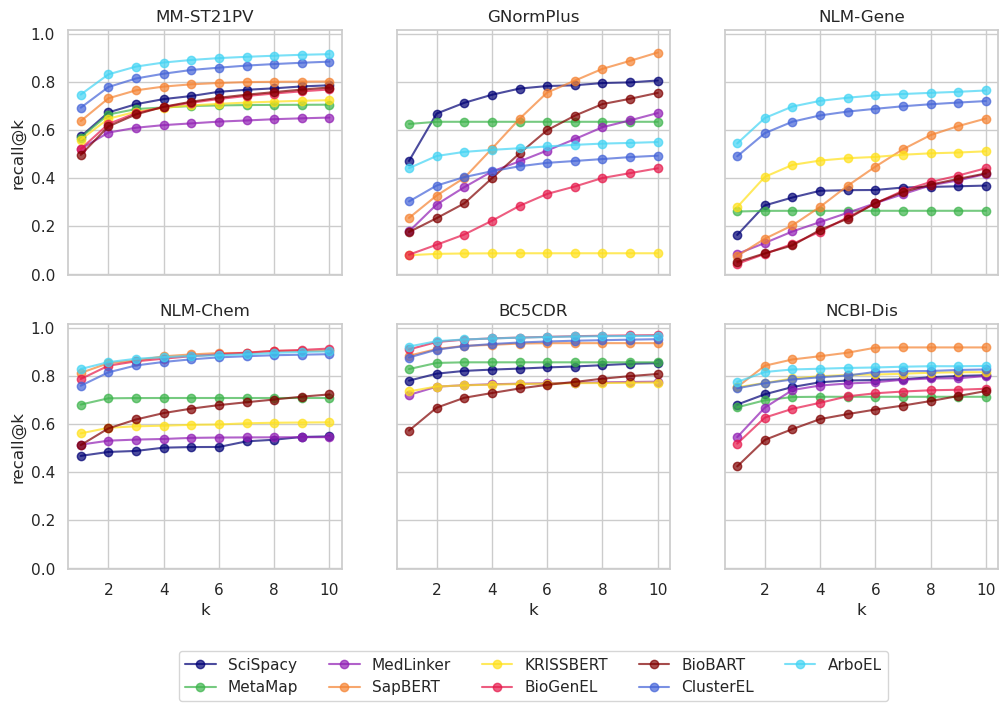

bc5cdr
medmentions_full
medmentions_st21pv
gnormplus
nlmchem
nlm_gene
ncbi_disease


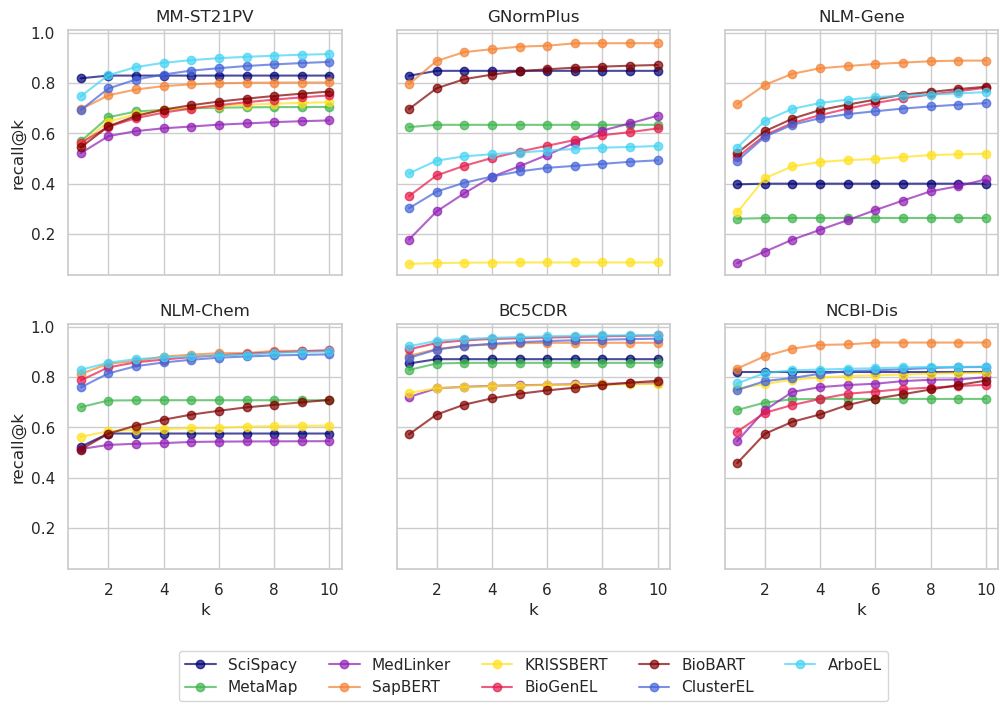

bc5cdr
medmentions_full
medmentions_st21pv
gnormplus
nlmchem
nlm_gene
ncbi_disease


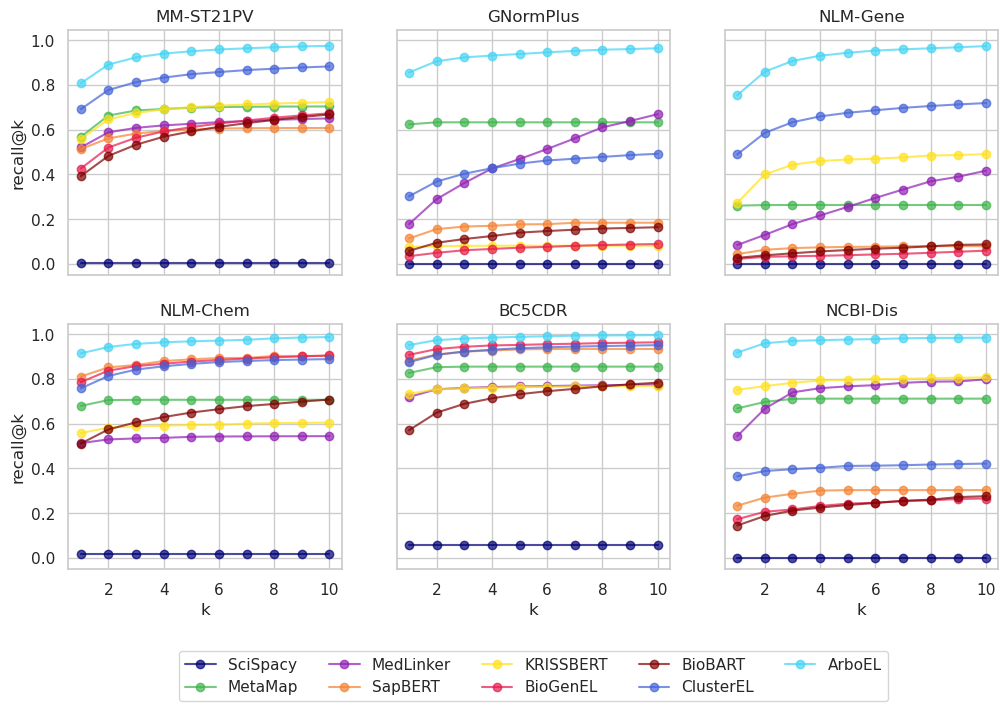

In [27]:
for eval_strategy in tqdm(['basic','relaxed','strict']):
    all_recall = recall_all_eval_strategies[eval_strategy]
    fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,7))

    dataset_to_subplot = {
        "bc5cdr":(1,1),
        "medmentions_full":None,
        "medmentions_st21pv":(0,0),
        "gnormplus":(0,1),
        "nlmchem":(1,0),
        "nlm_gene":(0,2),
        "ncbi_disease":(1,2),
    }

    plt.setp(axs[-1, :], xlabel='k')
    plt.setp(axs[:, 0], ylabel='recall@k')

    for name in DATASET_NAMES:
        recall_dict = all_recall[name]
        print(name)
        df = full_results[name]
        inds = dataset_to_subplot[name]
        if inds is not None:
            ax = axs[inds[0], inds[1]]
            
            ax.title.set_text(dataset_to_pretty_name[name])

        for model in ['scispacy','metamap','medlinker','sapbert','krissbert', 'biogenel','biobart','arboel_biencoder','arboel_crossencoder']:
            # if model == 'scispacy':
            #     recall_dict[model] = recall_at_k(df, model, gold_col='remapped_db_ids')
            # elif model == 'arboel_crossencoder' and name == 'medmentions_full':
            #     continue
            # else:
            #     recall_dict[model] = recall_at_k(df, model)
                
            if inds is None:
                continue
            else:
                plot_recall_at_k(recall_dict[model], legend_key=model_to_pretty_name[model], ax=ax, color=model_to_color[model], alpha=.7)

        
        plt.title(dataset_to_pretty_name[name])


    axs[1,1].legend(ncol=5, bbox_to_anchor =(0.5,-0.57), loc='lower center')
    plt.savefig(f'../figures/recall_at_k_{eval_strategy}.png', bbox_inches='tight', transparent="True", pad_inches=0)
    # fig.tight_layout()
    plt.show()

In [42]:
# Subplot to show how relaxed evaluation changes results
basic_recall = recall_all_eval_strategies['basic']
# basic_recall = {name: {model:val[1]} for name, d in recall_all_eval_strategies['basic'].items() for model, val in d.items()}
basic_dfs = []
for dataset, vals in basic_recall.items():
    recall_one_dataset = pd.DataFrame(vals)
    recall_one_dataset['dataset'] = dataset
    basic_dfs.append(recall_one_dataset)
basic_df = pd.concat(basic_dfs)
basic_df['eval_strategy'] = 'basic'
basic_df.query("index in [1,5]").reset_index().rename({'index':'k'}, axis=1)
# relaxed_recall = recall_all_eval_strategies['relaxed']

relaxed_recall = recall_all_eval_strategies['relaxed']
# relaxed_recall = {name: {model:val[1]} for name, d in recall_all_eval_strategies['relaxed'].items() for model, val in d.items()}
relaxed_dfs = []
for dataset, vals in relaxed_recall.items():
    recall_one_dataset = pd.DataFrame(vals)
    recall_one_dataset['dataset'] = dataset
    relaxed_dfs.append(recall_one_dataset)
relaxed_df = pd.concat(relaxed_dfs)
relaxed_df['eval_strategy'] = 'relaxed'
relaxed_df.query("index in [1]").reset_index().rename({'index':'k'}, axis=1)

recall_compare_df = pd.concat([basic_df, relaxed_df])

recall_compare_df



In [11]:
cols_to_keep

['sapbert_resolve_abbrev',
 'metamap_resolve_abbrev',
 'krissbert_resolve_abbrev',
 'scispacy_resolve_abbrev',
 'medlinker',
 'arboel_biencoder_resolve_abbrev',
 'arboel_crossencoder_resolve_abbrev',
 'biobart_resolve_abbrev',
 'biogenel_resolve_abbrev']

bc5cdr
medmentions_full
medmentions_st21pv
gnormplus
nlmchem
nlm_gene
ncbi_disease


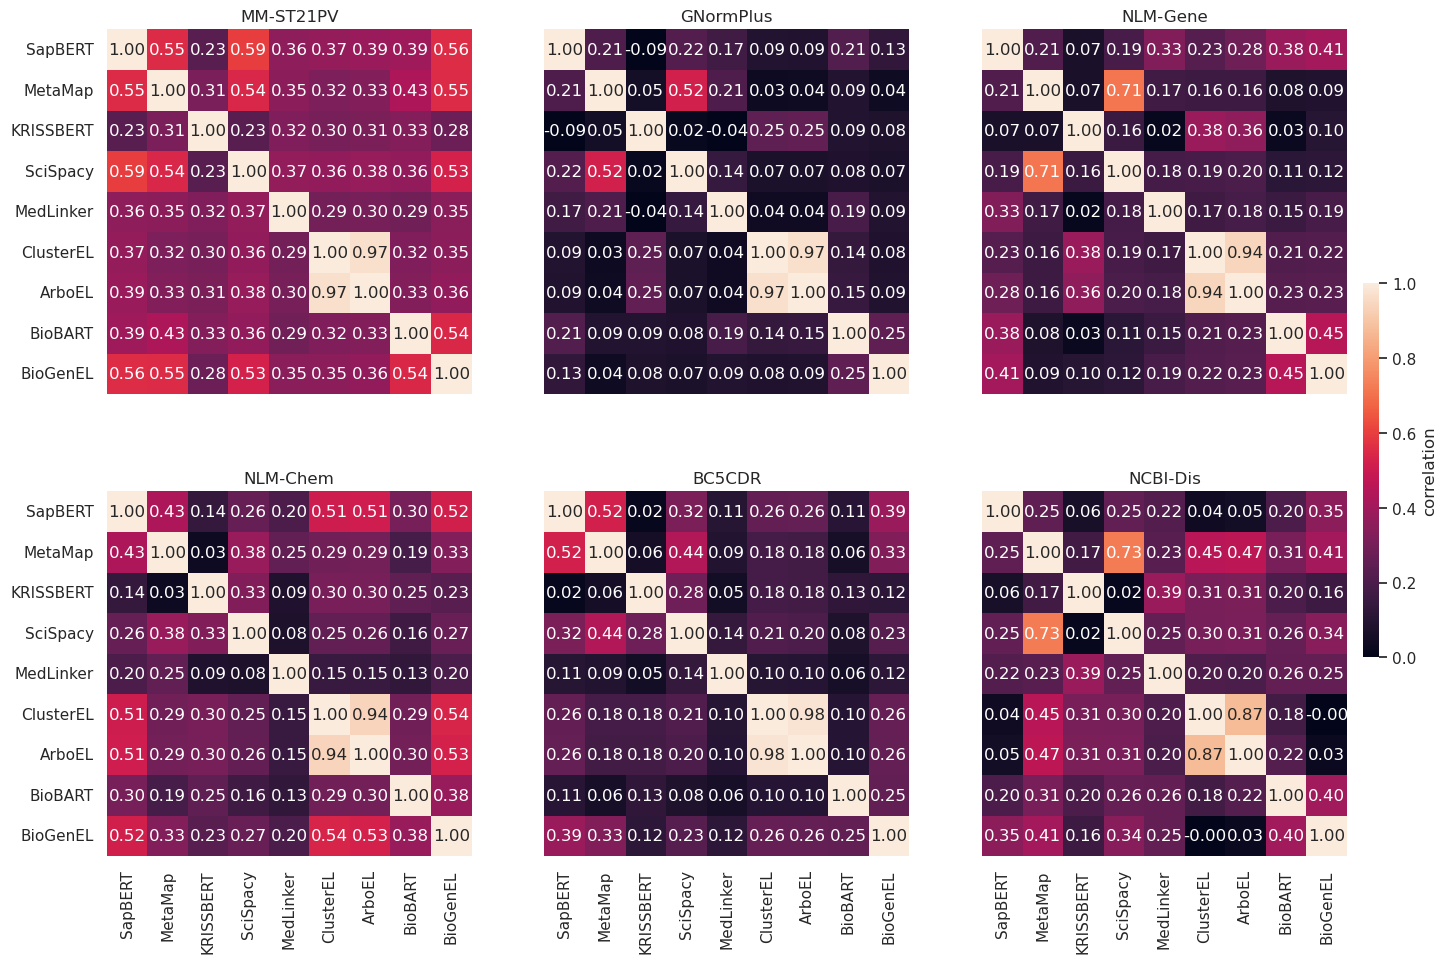

In [28]:
fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(16,11))
cbar_ax = cbar_ax = fig.add_axes([.91, 0.3, .01, .34])
resolve_abbrevs = True

# dataset_to_subplot = {
#     # "bc5cdr":(1,1),
#     # "medmentions_full":None,
#     "medmentions_st21pv":0,
#     # "gnormplus":(0,1),
#     "nlmchem":1,
#     "nlm_gene":2,
#     # "ncbi_disease":(1,2),
# }
dataset_to_subplot = {
    "bc5cdr":(1,1),
    # "medmentions_full":None,
    "medmentions_st21pv":(0,0),
    "gnormplus":(0,1),
    "nlmchem":(1,0),
    "nlm_gene":(0,2),
    "ncbi_disease":(1,2),
}

# plt.setp(axs[-1, :], xlabel='k')
# plt.setp(axs[:, 0], ylabel='recall@k')

for name in DATASET_NAMES:
    print(name)
    df = error_analysis_dfs['basic'][name]
    if name in dataset_to_subplot:
        inds = dataset_to_subplot[name]
        ax = axs[inds[0], inds[1]]
        ax.title.set_text(dataset_to_pretty_name[name])
    else:
        continue

    # display(df.head())

    # axs[-1].title.set_text('')

    # Deal with the fact that we abbr res didn't work on some models
    #      and that other models failed without abbre res
     
    # cols_to_keep = [x for x in df.columns if 'min_hit_index' in x]
    cols_to_keep = []
    for model in models:
        if resolve_abbrevs:
            col_name = f"{model}_resolve_abbrev"
            if col_name in df.columns:
                cols_to_keep.append(col_name)
            else:
                cols_to_keep.append(f"{model}")
        else:
            col_name = f"{model}"
            if col_name in df.columns:
                cols_to_keep.append(col_name)
            else:
                cols_to_keep.append(f"{model}_resolve_abbrev")
    
    subset = df[cols_to_keep]
    subset.columns = [x.replace('_min_hit_index','').replace('_resolve_abbrev','') for x in cols_to_keep]
    subset.columns = [model_to_pretty_name[x] for x in subset.columns]

    heatmap = sns.heatmap(subset.corr(), vmin=0, vmax=1, annot=True, ax=ax, cbar=True, fmt='.2f', cbar_ax=cbar_ax, cbar_kws={'label':'correlation'}, square=True)

    # if name == "nlm_gene":
    # print(name)
    # display(subset.head())
    # Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
    # heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);


    # for model in ['scispacy','metamap','medlinker','sapbert','krissbert', 'biogenel','biobart','arboel_biencoder','arboel_crossencoder']:
    #     subset = full_results[]
    #     # if model == 'scispacy':
    #     #     recall_dict[model] = recall_at_k(df, model, gold_col='remapped_db_ids')
    #     # elif model == 'arboel_crossencoder' and name == 'medmentions_full':
    #     #     continue
    #     # else:
    #     #     recall_dict[model] = recall_at_k(df, model)
            
    #     if inds is None:
    #         continue
    #     else:
    #         plot_recall_at_k(recall_dict[model], legend_key=model, ax=ax)

    
    # plt.title(dataset_to_pretty_name[name])


# axs[1,1].legend(ncol=5, bbox_to_anchor =(0.5,-0.57), loc='lower center')

# fig.tight_layout()
plt.savefig('../figures/correlation_heatmap.png', bbox_inches='tight', transparent="True", pad_inches=0)

plt.show()

# Generate main results table for paper

In [24]:
eval_strategy = 'basic'
all_recall = recall_all_eval_strategies['basic']
num_datasets = 2 * len(DATASET_NAMES)
cols1 = []
cols2 = []
for name in DATASET_NAMES:
    cols1.extend(2*[dataset_to_pretty_name[name]])
    cols2.extend(['1','5'])
col_multiindex = [cols1, cols2]


num_models = len(models)
model_output = np.zeros((num_models, num_datasets))
for i, model in enumerate(models):
    for j, dataset in enumerate(DATASET_NAMES):
        if model not in all_recall[dataset]:
            continue
        model_output[i, 2*j] = all_recall[dataset][model][1]
        model_output[i, 2*j + 1] = all_recall[dataset][model][5]


print(pd.DataFrame(data=model_output, index=[model_to_pretty_name[model] for model in models], columns=col_multiindex).round(3).to_latex(bold_rows=True,))
    

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{2}{l}{BC5CDR} & \multicolumn{2}{l}{MM-Full} & \multicolumn{2}{l}{MM-ST21PV} & \multicolumn{2}{l}{GNormPlus} & \multicolumn{2}{l}{NLM-Chem} & \multicolumn{2}{l}{NLM-Gene} & \multicolumn{2}{l}{NCBI-Dis} \\
{} &      1 &      5 &       1 &      5 &         1 &      5 &         1 &      5 &        1 &      5 &        1 &      5 &        1 &      5 \\
\midrule
\textbf{SapBERT  } &  0.883 &  0.934 &   0.611 &  0.799 &     0.637 &  0.789 &     0.234 &  0.646 &    0.812 &  0.889 &    0.075 &  0.368 &    0.753 &  0.896 \\
\textbf{MetaMap  } &  0.828 &  0.856 &   0.588 &  0.731 &     0.568 &  0.699 &     0.624 &  0.633 &    0.680 &  0.707 &    0.261 &  0.263 &    0.669 &  0.712 \\
\textbf{KRISSBERT} &  0.735 &  0.766 &   0.591 &  0.755 &     0.559 &  0.701 &     0.079 &  0.087 &    0.560 &  0.596 &    0.279 &  0.482 &    0.752 &  0.803 \\
\textbf{SciSpacy } &  0.780 &  0.830 &   0.582 &  0.759 &     0.572 &  0.741 &     0.471 &  0.772 &

/tmp/ipykernel_22984/1195993052.py:22: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(data=model_output, index=[model_to_pretty_name[model] for model in models], columns=col_multiindex).round(3).to_latex(bold_rows=True,))


# Subtype analysis on MedMentions ST21PV
* Exact match in training data
* Entity in training data but not exact match
* Entity not in training data
* No alias match (case insensitive)
* Incorrect alias match

In [71]:
# Load train dataframe
name = 'medmentions_st21pv'
dataset = conhelps.for_config_name(f'{name}_bigbio_kb').load_dataset()
exclude = CUIS_TO_EXCLUDE[name]
remap = CUIS_TO_REMAP[name]
train = dataset_to_df(dataset, cuis_to_exclude=exclude, entity_remapping_dict=remap, splits_to_include=['train'])

# Make boolean cols to filter dataframe



Found cached dataset medmentions (/home/dkartchner3/.cache/huggingface/datasets/medmentions/medmentions_st21pv_bigbio_kb/1.0.0/3fc6b8a3681d540ae6c7497c238636b543b90764247b5ff3642d243474000794)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
train_mention_text = set(train.text.tolist())
train_mention_entities = set([y for x in train.db_ids.tolist() for y in x])



# Subtypes Analysis of NLM-Gene

In [ ]:
#

# MedLinker

In [29]:
output = ujson.load(open(f'../results/medlinker/{name}.json'))
output

[{'document_id': '8701013',
  'offsets': [['22', '30']],
  'text': 'delirium',
  'type': 'Disease',
  'db_ids': ['MESH:D003693'],
  'split': 'test',
  'candidates': [['MESH:D003693'],
   ['ESH:D003693'],
   ['MESH:D000430'],
   ['MESH:D000071257'],
   ['MESH:D012967'],
   ['MESH:C026718'],
   ['MESH:D065166'],
   ['MESH:D017257'],
   ['MESH:D003903'],
   ['MESH:D019965'],
   ['MESH:D031882'],
   ['MESH:C100193'],
   ['MESH:D003476'],
   ['MESH:D030007'],
   ['MESH:D002123'],
   ['MESH:D002563'],
   ['MESH:D006371'],
   ['MESH:D020405'],
   ['MESH:D001464'],
   ['MESH:D064752'],
   ['MESH:C491916'],
   ['MESH:D008472'],
   ['MESH:D015019'],
   ['MESH:D001556'],
   ['MESH:D008063']]},
 {'document_id': '8701013',
  'offsets': [['55', '65']],
  'text': 'Famotidine',
  'type': 'Chemical',
  'db_ids': ['MESH:D015738'],
  'split': 'test',
  'candidates': [['MESH:D015738'],
   ['MESH:C000435'],
   ['MESH:C023990'],
   ['MESH:C008714'],
   ['MESH:C043465'],
   ['MESH:C075156'],
   ['MESH:C06210

# KRISSBERT

In [19]:
krissbert_output = ujson.load(open(f'../results/krissbert/{name}.json'))
krissbert2candidates = output_list_to_candidates(krissbert_output)
add_candidates_to_df(df, krissbert2candidates, 'krissbert')
df


  0%|          | 0/9750 [00:00<?, ?it/s]

,document_id,offsets,text,type,db_ids,split,mention_id,deabbreviated_text,scispacy,scispacy_resolve_abbrev,joined_offsets,sapbert,krissbert
0,10087562,"[[0, 18]]",Torsade de pointes,[Disease],[MESH:D016171],test,10087562.1,Torsade de pointes,"[MESH:D016171, MESH:D000077588, MESH:D00006771...","[MESH:D016171, MESH:D000077588, MESH:D00006771...","0,18","[MESH:D016171, MESH:D016171, MESH:D016171, MES...","[MESH:D016171, MESH:D017180, MESH:D008133, MES..."
1,10087562,"[[19, 42]]",ventricular tachycardia,[Disease],[MESH:D017180],test,10087562.2,ventricular tachycardia,"[MESH:D017180, MESH:D016170, MESH:D013617, MES...","[MESH:D017180, MESH:D016170, MESH:D013617, MES...","19,42","[MESH:D017180, MESH:D017180, MESH:D017180, MES...","[MESH:D017180, MESH:D017180, MESH:D013617, MES..."
2,10087562,"[[72, 82]]",dobutamine,[Chemical],[MESH:D004280],test,10087562.3,dobutamine,"[MESH:D004280, MESH:D025401, MESH:D005973, MES...","[MESH:D004280, MESH:D025401, MESH:D005973, MES...","72,82","[MESH:D004280, MESH:D004280, MESH:D004280, MES...","[MESH:D004280, MESH:D004280, MESH:D004298, MES..."
3,10087562,"[[111, 133]]",dilated cardiomyopathy,[Disease],[MESH:D002311],test,10087562.4,dilated cardiomyopathy,"[MESH:D002311, MESH:D020388, MESH:D054549, MES...","[MESH:D002311, MESH:D020388, MESH:D054549, MES...","111,133","[MESH:D002311, MESH:D002311, MESH:D002311, MES...","[MESH:D002311, MESH:D002311, MESH:D009202, MES..."
4,10087562,"[[138, 162]]",congestive heart failure,[Disease],[MESH:D006333],test,10087562.5,congestive heart failure,"[MESH:D006333, MESH:D054143, MESH:D054144, MES...","[MESH:D006333, MESH:D054143, MESH:D054144, MES...","138,162","[MESH:D006333, MESH:D006333, MESH:D006333, MES...","[MESH:D006333, MESH:D006333, MESH:D002318, MES..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9745,9889429,"[[1001, 1011]]",nifedipine,[Chemical],[MESH:D009543],test,9889429.17,nifedipine,"[MESH:D009543, MESH:D009529, MESH:D009553, MES...","[MESH:D009543, MESH:D009529, MESH:D009553, MES...","1001,1011","[MESH:D009543, MESH:C033710, MESH:C475960, MES...","[MESH:D009543, MESH:D009543, MESH:D009568, MES..."
9746,9889429,"[[1026, 1038]]",hypertensive,[Disease],[MESH:D006973],test,9889429.18,hypertensive,"[MESH:D000802, MESH:D006973, MESH:D020303, MES...","[MESH:D000802, MESH:D006973, MESH:D020303, MES...","1026,1038","[MESH:D006973, MESH:D006973, MESH:D006973, MES...","[MESH:D006973, MESH:D006973, MESH:D007022, MES..."
9747,9889429,"[[1039, 1048]]",psoriatic,[Disease],[MESH:D011565],test,9889429.19,psoriatic,"[MESH:D015535, MESH:D000075023, MESH:D011565, ...","[MESH:D015535, MESH:D000075023, MESH:D011565, ...","1039,1048","[MESH:D011565, MESH:D015535, MESH:D015535, MES...","[MESH:D011565, MESH:D003872, MESH:D001172, MES..."
9748,9889429,"[[1089, 1102]]",cyclosporin A,[Chemical],[MESH:D016572],test,9889429.20,cyclosporin A,"[MESH:D016572, MESH:D003524, MESH:D021744, MES...","[MESH:D016572, MESH:D003524, MESH:D021744, MES...","1089,1102","[MESH:D016572, MESH:D016572, MESH:C061713, MES...","[MESH:D016572, MESH:D016572, MESH:D016559, MES..."


# BioGenEL

In [4]:
biogen_dict = ujson.load(open('../biogenel/src/bigbio_/output/bc5cdr.json'))

db_ids = [x['db_ids'] for x in biogen]
biogen_candidates = [[z for y in  x['candidates'] for z in y] for x in biogen_dict]
biogen_candidates

head = df.head(100)
head['biogenel_resolve_abbrev'] = biogen_candidates
head

NameError: name 'biogen' is not defined

In [9]:
head_ids = df.head(100).db_ids.tolist()


In [14]:
for x, y in zip(db_ids, head_ids):
    if len(set(x).intersection(set(y))) != len(y):
        print(x, y)

In [5]:
biogen_dict

[{'db_ids': ['MESH:D016171'],
  'candidates': [['MESH:D016171'],
   ['MESH:D016171'],
   ['MESH:D017180'],
   ['MESH:D016171'],
   ['MESH:D016171'],
   ['MESH:D004280'],
   ['MESH:D014325'],
   ['MESH:D016171'],
   ['MESH:D018754'],
   ['MESH:Q000188']],
  'candidates_metadata': [{'text': 'torsade de pointes',
    'db_id': ['MESH:D016171']},
   {'text': 'torsades de pointes', 'db_id': ['MESH:D016171']},
   {'text': 'ventricular tachycardia', 'db_id': ['MESH:D017180']},
   {'text': 'pointes, torsade de', 'db_id': ['MESH:D016171']},
   {'text': 'de pointes, torsade', 'db_id': ['MESH:D016171']},
   {'text': 'dobutamine', 'db_id': ['MESH:D004280']},
   {'text': 'tromethamine', 'db_id': ['MESH:D014325']},
   {'text': 'de pointes, torsades', 'db_id': ['MESH:D016171']},
   {'text': 'ventricular dysfunctions', 'db_id': ['MESH:D018754']},
   {'text': 'dt', 'db_id': ['MESH:Q000188']}]},
 {'db_ids': ['MESH:D017180'],
  'candidates': [['MESH:D017180'],
   ['MESH:D016171'],
   ['MESH:D017180'],
   